# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [13]:
# Importing required imports

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Importing necessary functions from common_utils.py module.
from common_utils import set_seed, split_dataset, preprocess_dataset, EarlyStopper

# setting seed
SEED = 0
set_seed(SEED)

1. Define the model class.

In [14]:
class MLP(nn.Module):
    # Initialize the model parameters
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()  # Call the parent class constructor
        
        # Define the neural network layers and their sequence
        self.mlp_stack = nn.Sequential(
            # First hidden layer
            nn.Linear(no_features, no_hidden),   # Linear layer with 'no_features' inputs and 'no_hidden' outputs (128 in this case)
            nn.ReLU(),                           # Rectified Linear Unit (ReLU) activation function
            nn.Dropout(0.2),                     # Dropout layer to prevent overfitting, drops 20% of the neurons
            
            # Second hidden layer
            nn.Linear(no_hidden, 128),           # Another linear layer with 'no_hidden' inputs and 128 outputs 
            nn.ReLU(),                           # ReLU activation function
            nn.Dropout(0.2),                     # Dropout layer with 20% dropout rate
            
            # Third hidden layer
            nn.Linear(128, 128),                 # Third linear layer with 128 inputs and 128 outputs 
            nn.ReLU(),                           # ReLU activation function
            nn.Dropout(0.2),                     # Dropout layer with 20% dropout rate
            
            # Output layer
            nn.Linear(128, no_labels),           # Linear layer to produce final output. 128 inputs and 'no_labels' outputs.
            nn.Sigmoid()                         # Sigmoid activation function for binary classification
        )

    # Define the forward pass
    def forward(self, x):
        # Pass the input through the mlp_stack to get the output
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.


1. Split the dataset and do preprocessing.

In [15]:
def preprocess(df):
    
    # Dropping Unnecessary Columns and Splitting the Dataset:
    # The dataset column called filename is likely a unique identifier for each sample and not a feature we would use for modeling. Hence, we should remove it before feeding the data to our model. 
    columns_to_drop = ['filename', 'label']

    # Splitting the dataset into training and testing sets:
    # The split is done in a 70:30 ratio, and the random_state ensures reproducibility.
    df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

    # Scaling the Features:
    # Feature scaling is crucial for many ML algorithms. It makes the algorithm faster and more accurate.
    # Here, the mean and standard deviation of the training data is used to standardize both training and testing data.
    X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test)

    # Returning the processed datasets.
    return X_train_scaled, y_train, X_test_scaled, y_test

set_seed(SEED)

# Loading the dataset from a CSV file.
df = pd.read_csv('simplified.csv')

# Extracting the 'label' from the 'filename' column.
# It appears the label is embedded in the filename and is the penultimate (second last) item when split by '_'.
df['label'] = df['filename'].str.split('_').str[-2]

# Checking the distribution of the labels.
print(df['label'].value_counts())

# Calling the preprocess function to get training and testing datasets.
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
# Explanation on why we used StandardScaler for preprocessing and why it's appropriate:

# Utilizing the StandardScaler for preprocessing is appropriate for our neural network model, especially when the dataset contains diverse features with different scales, like in the 
# National Speech Corpus. Neural networks tend to perform optimally when input data is standardized. Features with larger scales can disproportionately impact the training, causing slower 
# convergence. With StandardScaler, all features are standardized to have a mean of 0 and a standard deviation of 1. This ensures that each feature has a consistent influence during 
# training, leading to faster and more stable convergence. Given the diverse features in our project, such as MFCCs and chromagrams, this standardization is crucial for balanced training.
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

label
pos    6202
neg    5855
Name: count, dtype: int64


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [16]:
class CustomDataset(Dataset):
    # Constructor: called when an object is created from the class
    def __init__(self, X, y):
        # Convert the input arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)   # Converts input data to float32 dtype tensor
        self.y = torch.tensor(y, dtype=torch.long)      # Converts labels to long dtype tensor as it's used for classification tasks

    # Returns the length of the dataset
    def __len__(self):
        return len(self.y)

    # Allows the dataset to be indexed so that it can work with PyTorch's DataLoader
    # For the given index 'idx', it returns the input data and its corresponding label
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # Create dataset objects
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)
    
    # Create DataLoader objects to enable batch processing and shuffling
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)    # Shuffling helps in better optimization during training
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False)     # Shuffling is not necessary during testing/evaluation
    
    return train_dataloader, test_dataloader
set_seed()
train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [17]:
set_seed(SEED)
# Initialize the model
no_features = X_train_scaled.shape[1] # Input patterns
no_hidden = 128  # 128 hidden layers for the first hidden layer
no_labels = 1

model = MLP(no_features, no_hidden, no_labels)

# Loss Function
loss_fn = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [18]:
# Function to run the training loop for each epoch
def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)  # Total number of samples in the dataset
    train_loss, correct = 0, 0  # Initialize loss and correct predictions counter
    model.train()
    # Iterate over batches of data in the training dataloader
    for X, y in train_dataloader:
        pred = model(X).squeeze()  # Predict with the model and squeeze to remove dimension of size 1
        loss = loss_fn(pred, y.float())  # Compute the loss between prediction and true label
        
        # Calculate the number of correct predictions for the current batch
        predicted = (pred > 0.5).long()  # Since it's binary classification, threshold the output at 0.5
        correct += (predicted == y).sum().item()  # Count the number of correct predictions

        optimizer.zero_grad()  # Reset the optimizer's gradient (to prevent accumulation)
        loss.backward()  # Compute gradient through backpropagation
        optimizer.step()  # Apply the gradient to update model parameters
    
        train_loss += loss.item()  # Accumulate the loss

    train_loss /= size  # Average the loss over the entire dataset
    train_accuracy = correct / size  # Calculate the accuracy
    return train_loss, train_accuracy

# Function to run the test loop for each epoch
def test_loop(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)  # Total number of samples in the dataset
    test_loss, correct = 0, 0  # Initialize loss and correct predictions counter
    model.eval()
    # No gradient computation is needed during evaluation
    with torch.no_grad():
        for X, y in test_dataloader:  # Iterate over batches of data in the test dataloader
            pred =  model(X).squeeze()  # Predict with the model and squeeze to remove dimension of size 1
            test_loss += loss_fn(pred, y.float()).item()  # Accumulate the loss
            
            predicted = (pred > 0.5).long()  # Threshold the prediction for binary classification
            correct += (predicted == y).sum().item()  # Count the number of correct predictions

    test_loss /= size  # Average the loss over the entire dataset
    test_accuracy = correct / size  # Calculate the accuracy
    return test_loss, test_accuracy


set_seed(SEED)

train_loss_, test_loss_ = [], []
train_acc_, test_acc_ = [], []
best_test_accuracy = 0
num_epochs = 100

# Instantiate the EarlyStopper class
early_stopper = EarlyStopper(patience=3, min_delta=0)

print("Training Started...", flush=True)
print()

# Start training for 100 epochs
for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    # Store results for later plotting
    train_loss_.append(train_loss)
    test_loss_.append(test_loss)
    train_acc_.append(train_accuracy)
    test_acc_.append(test_accuracy)

    print(f"Epoch {epoch+1:>2}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Check for early stopping
    if early_stopper.early_stop(test_loss):
        print(f"Early stopping on epoch {epoch+1}")
        print(f"Epoch {epoch+1:>2}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        break

print()
print("Training Completed!")

Training Started...



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<01:03,  1.57it/s]

Epoch  1, Train Loss: 0.0027, Train Accuracy: 0.5283, Test Loss: 0.0028, Test Accuracy: 0.5547


  2%|▏         | 2/100 [00:01<00:53,  1.84it/s]

Epoch  2, Train Loss: 0.0026, Train Accuracy: 0.5790, Test Loss: 0.0028, Test Accuracy: 0.5882


  3%|▎         | 3/100 [00:01<00:50,  1.91it/s]

Epoch  3, Train Loss: 0.0026, Train Accuracy: 0.5992, Test Loss: 0.0027, Test Accuracy: 0.6056


  4%|▍         | 4/100 [00:02<00:46,  2.08it/s]

Epoch  4, Train Loss: 0.0025, Train Accuracy: 0.6208, Test Loss: 0.0027, Test Accuracy: 0.6224


  5%|▌         | 5/100 [00:02<00:43,  2.17it/s]

Epoch  5, Train Loss: 0.0025, Train Accuracy: 0.6360, Test Loss: 0.0027, Test Accuracy: 0.6299


  6%|▌         | 6/100 [00:02<00:41,  2.27it/s]

Epoch  6, Train Loss: 0.0024, Train Accuracy: 0.6567, Test Loss: 0.0026, Test Accuracy: 0.6479


  7%|▋         | 7/100 [00:03<00:41,  2.26it/s]

Epoch  7, Train Loss: 0.0024, Train Accuracy: 0.6757, Test Loss: 0.0026, Test Accuracy: 0.6625


  8%|▊         | 8/100 [00:03<00:41,  2.24it/s]

Epoch  8, Train Loss: 0.0023, Train Accuracy: 0.6852, Test Loss: 0.0025, Test Accuracy: 0.6810


  9%|▉         | 9/100 [00:04<00:39,  2.28it/s]

Epoch  9, Train Loss: 0.0022, Train Accuracy: 0.6983, Test Loss: 0.0025, Test Accuracy: 0.6772


 10%|█         | 10/100 [00:04<00:38,  2.31it/s]

Epoch 10, Train Loss: 0.0022, Train Accuracy: 0.7093, Test Loss: 0.0024, Test Accuracy: 0.6976


 11%|█         | 11/100 [00:05<00:41,  2.16it/s]

Epoch 11, Train Loss: 0.0021, Train Accuracy: 0.7222, Test Loss: 0.0024, Test Accuracy: 0.6976


 12%|█▏        | 12/100 [00:05<00:39,  2.23it/s]

Epoch 12, Train Loss: 0.0021, Train Accuracy: 0.7295, Test Loss: 0.0024, Test Accuracy: 0.7142


 13%|█▎        | 13/100 [00:06<00:42,  2.06it/s]

Epoch 13, Train Loss: 0.0020, Train Accuracy: 0.7436, Test Loss: 0.0023, Test Accuracy: 0.7167


 14%|█▍        | 14/100 [00:06<00:44,  1.94it/s]

Epoch 14, Train Loss: 0.0020, Train Accuracy: 0.7487, Test Loss: 0.0023, Test Accuracy: 0.7150


 15%|█▌        | 15/100 [00:07<00:47,  1.77it/s]

Epoch 15, Train Loss: 0.0019, Train Accuracy: 0.7642, Test Loss: 0.0023, Test Accuracy: 0.7253


 16%|█▌        | 16/100 [00:07<00:46,  1.81it/s]

Epoch 16, Train Loss: 0.0019, Train Accuracy: 0.7712, Test Loss: 0.0023, Test Accuracy: 0.7313


 17%|█▋        | 17/100 [00:08<00:41,  2.02it/s]

Epoch 17, Train Loss: 0.0018, Train Accuracy: 0.7704, Test Loss: 0.0022, Test Accuracy: 0.7360


 18%|█▊        | 18/100 [00:08<00:39,  2.10it/s]

Epoch 18, Train Loss: 0.0018, Train Accuracy: 0.7766, Test Loss: 0.0023, Test Accuracy: 0.7231


 19%|█▉        | 19/100 [00:09<00:35,  2.29it/s]

Epoch 19, Train Loss: 0.0018, Train Accuracy: 0.7858, Test Loss: 0.0022, Test Accuracy: 0.7349


 20%|██        | 20/100 [00:09<00:32,  2.43it/s]

Epoch 20, Train Loss: 0.0017, Train Accuracy: 0.7904, Test Loss: 0.0022, Test Accuracy: 0.7394


 21%|██        | 21/100 [00:09<00:36,  2.19it/s]

Epoch 21, Train Loss: 0.0017, Train Accuracy: 0.8038, Test Loss: 0.0022, Test Accuracy: 0.7430


 22%|██▏       | 22/100 [00:10<00:32,  2.39it/s]

Epoch 22, Train Loss: 0.0016, Train Accuracy: 0.8045, Test Loss: 0.0023, Test Accuracy: 0.7333


 23%|██▎       | 23/100 [00:10<00:30,  2.57it/s]

Epoch 23, Train Loss: 0.0016, Train Accuracy: 0.8079, Test Loss: 0.0022, Test Accuracy: 0.7488


 24%|██▍       | 24/100 [00:10<00:28,  2.66it/s]

Epoch 24, Train Loss: 0.0016, Train Accuracy: 0.8223, Test Loss: 0.0022, Test Accuracy: 0.7441


 25%|██▌       | 25/100 [00:11<00:28,  2.59it/s]

Epoch 25, Train Loss: 0.0015, Train Accuracy: 0.8169, Test Loss: 0.0022, Test Accuracy: 0.7526


 26%|██▌       | 26/100 [00:11<00:28,  2.56it/s]

Epoch 26, Train Loss: 0.0015, Train Accuracy: 0.8218, Test Loss: 0.0022, Test Accuracy: 0.7532


 27%|██▋       | 27/100 [00:12<00:30,  2.39it/s]

Epoch 27, Train Loss: 0.0015, Train Accuracy: 0.8215, Test Loss: 0.0022, Test Accuracy: 0.7507


 28%|██▊       | 28/100 [00:12<00:30,  2.37it/s]

Epoch 28, Train Loss: 0.0015, Train Accuracy: 0.8266, Test Loss: 0.0022, Test Accuracy: 0.7471


 28%|██▊       | 28/100 [00:13<00:33,  2.15it/s]

Epoch 29, Train Loss: 0.0015, Train Accuracy: 0.8259, Test Loss: 0.0022, Test Accuracy: 0.7443
Early stopping on epoch 29
Epoch 29, Train Loss: 0.0015, Train Accuracy: 0.8259, Test Loss: 0.0022, Test Accuracy: 0.7443

Training Completed!


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


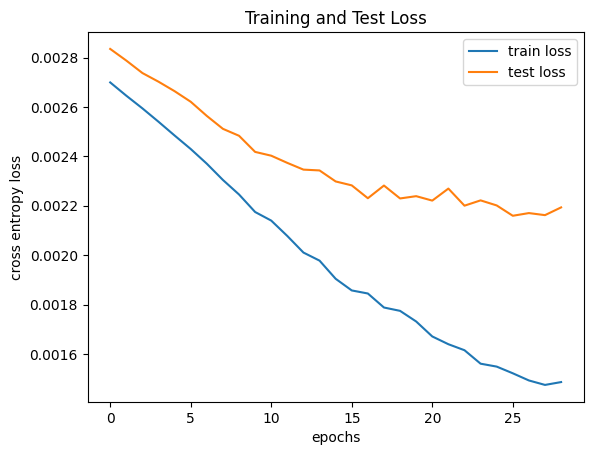

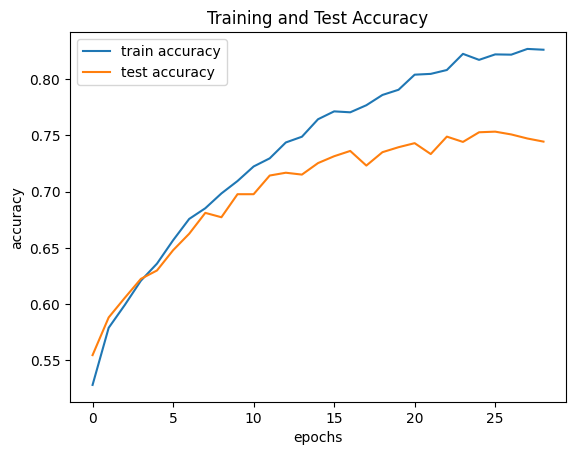

In [10]:
# YOUR CODE HERE

no_epochs = len(train_loss_) 

# Plotting the losses
plt.figure(1)
plt.plot(range(no_epochs), train_loss_, label='train loss')
plt.plot(range(no_epochs), test_loss_, label='test loss')
plt.title('Training and Test Loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend()

# Plotting the accuracies
plt.figure(2)
plt.plot(range(no_epochs), train_acc_, label='train accuracy')
plt.plot(range(no_epochs), test_acc_, label='test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

2. Comment on line plots.

In [19]:
# YOUR CODE HERE
answer = '''
• Training Metrics: The training loss consistently decreased across epochs, starting from 0.0027 to 0.0015, and the training accuracy increased from 55.47% to 82.59%. This indicates that 
the model is effectively learning and adjusting its weights based on the training data. This consistent improvement in training metrics is expected as the model becomes better at fitting the 
training data over successive epochs.

• Testing Metrics & Early Stopping: The testing accuracy increased from 55.47% to a peak of 74.43%. However, the testing loss decreased initially but then started to increase, which might 
suggest the beginning of overfitting. This is also supported by the observation that the training accuracy was continuously rising, but the test accuracy started to plateau. 
The early stopping mechanism proved beneficial by terminating the training process at epoch 29, before the model could overfit further. 

• General Observation: The divergence between training and testing metrics is indicative of a generalization gap. While the training metrics suggest the model is performing better with each 
epoch, the testing metrics show a different story. This disparity can be due to the model starting to memorize the training data and becoming less effective at generalizing to unseen data. 

• Potential Recommendations: The early stopping worked as intended, but if overfitting continues to be an issue, techniques like weight decay using L1 or L2 regularization
might be beneficial. Additionally, gathering more diverse training data, if possible, or employing data augmentation techniques might help in improving the model's generalization capabilities. 

In summary, the model has shown decent learning capabilities. However, there is room for improvement, especially in bridging the gap between training and testing performances.
'''

print(answer)



• Training Metrics: The training loss consistently decreased across epochs, starting from 0.0027 to 0.0015, and the training accuracy increased from 55.47% to 82.59%. This indicates that 
the model is effectively learning and adjusting its weights based on the training data. This consistent improvement in training metrics is expected as the model becomes better at fitting the 
training data over successive epochs.

• Testing Metrics & Early Stopping: The testing accuracy increased from 55.47% to a peak of 74.43%. However, the testing loss decreased initially but then started to increase, which might 
suggest the beginning of overfitting. This is also supported by the observation that the training accuracy was continuously rising, but the test accuracy started to plateau. 
The early stopping mechanism proved beneficial by terminating the training process at epoch 29, before the model could overfit further. 

• General Observation: The divergence between training and testing metrics is 